# Color balancing

Завантажимо зображення та подивимось розподіл інтенсивності пікселів.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

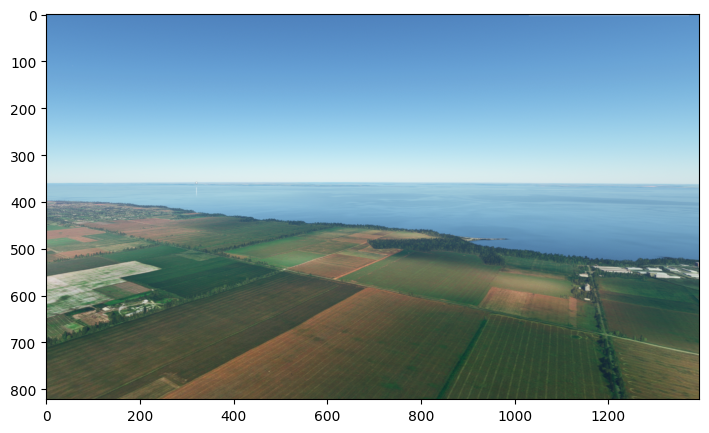

In [2]:
# Load your image
img = cv2.imread('dron_image.png')  # Завантажте своє зображення
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Гістограма візуалізує розподіл інтенсивності пікселів у зображенні за їхніми значеннями кольорів. На горизонтальній вісі розташовані значення кольорів (від 0 до 255), а на вертикальній вісі відображається кількість пікселів у зображенні, які мають відповідне значення кольору.

Elapsed time: 0.05796313285827637


([<matplotlib.lines.Line2D at 0x1b626edab10>], None)

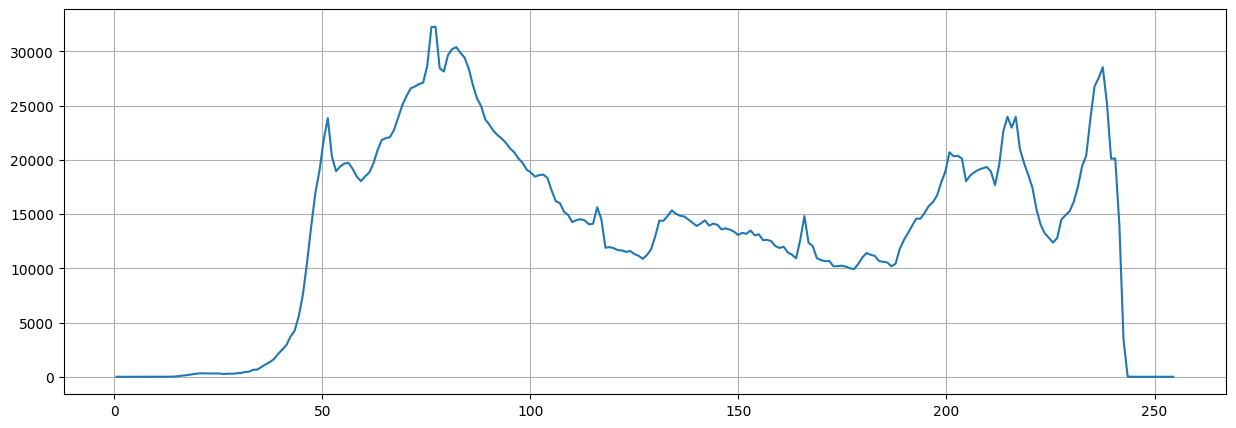

In [3]:
from time import time

start = time()
hist, bins = np.histogram(img.ravel(), bins=256, range=(0,255))
print('Elapsed time:', time() - start)
plt.plot(bins[0:-1]+0.5, hist), plt.grid(True)

## White patch

(<Axes: >, <matplotlib.image.AxesImage at 0x1b626eda450>)

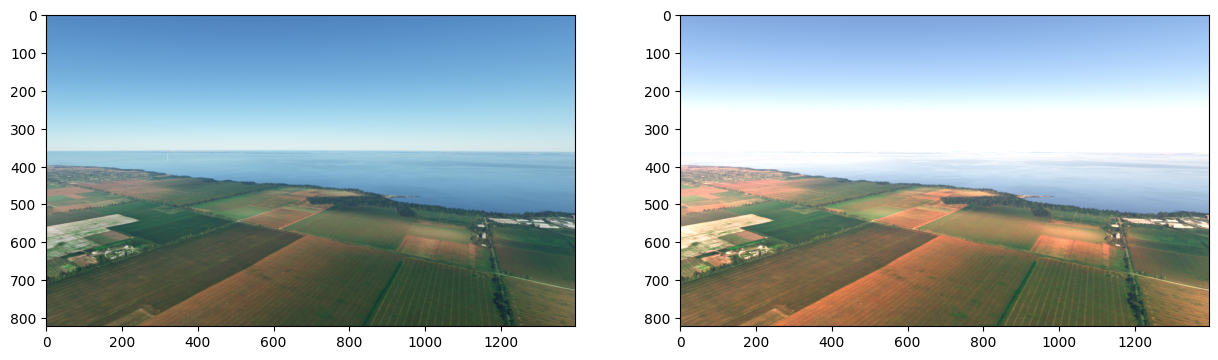

In [4]:
# Define white patch and the coefficients
row, col = 380, 350 
white = img[row, col, :]
coeffs = 255.0/white

# Apply white balancing and generate balanced image
balanced = np.zeros_like(img, dtype=np.float32)
for channel in range(3):
    balanced[..., channel] = img[..., channel] * coeffs[channel]

# White patching does not guarantee that the dynamic range is preserved, images must be clipped.
balanced = balanced/255
balanced[balanced > 1] = 1

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(balanced)

Подивимось відсоток пікселів у зображенні, які мають значення кольору менше або рівно певному значенню.

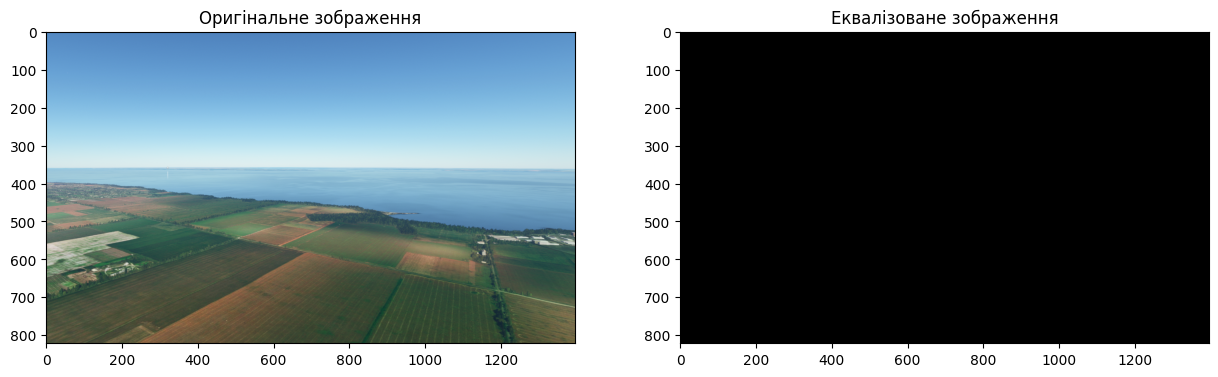

In [5]:
# Обчислення еквалізованого зображення
cdf = np.zeros(256)
equalized = np.interp(img, np.arange(256), 255 * cdf).astype(np.uint8)

# Відображення оригінального та еквалізованого зображення
plt.subplot(121), plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Оригінальне зображення')
plt.subplot(122), plt.imshow(equalized, cmap='gray', vmin=0, vmax=255)
plt.title('Еквалізоване зображення')
plt.show()


Координати найсвітлішого пікселя: (299, 575)


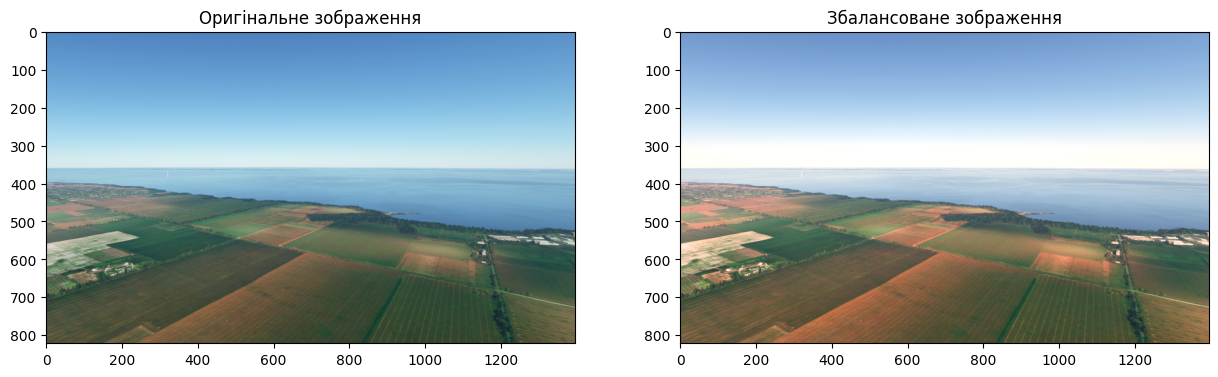

In [6]:
# Застосування розмиття для зменшення різниці між пікселями
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Знаходження координат найсвітлішого пікселя для кожного кольорового каналу
brightest_pixel_r = np.unravel_index(np.argmax(blurred_img[:,:,0]), blurred_img[:,:,0].shape)
brightest_pixel_g = np.unravel_index(np.argmax(blurred_img[:,:,1]), blurred_img[:,:,1].shape)
brightest_pixel_b = np.unravel_index(np.argmax(blurred_img[:,:,2]), blurred_img[:,:,2].shape)

# Обираємо найяскравіший піксель серед всіх каналів
brightest_pixel = (brightest_pixel_r[0], brightest_pixel_r[1])  # Початкове припущення

for pixel in [brightest_pixel_g, brightest_pixel_b]:
    if np.max(blurred_img[pixel]) > np.max(blurred_img[brightest_pixel]):
        brightest_pixel = (pixel[0], pixel[1])

# Виведення знайдених координат найсвітлішої точки
print("Координати найсвітлішого пікселя:", brightest_pixel)

# Використання координат найсвітлішого пікселя для балансування кольору
row, col = brightest_pixel

# Визначення білого патча та коефіцієнтів балансування
white = img[row, col, :]
coeffs = 255.0 / white

# Застосування балансування кольору і створення збалансованого зображення
balanced = np.zeros_like(img, dtype=np.float32)
for channel in range(3):
    balanced[..., channel] = img[..., channel] * coeffs[channel]

# Обмеження динамічного діапазону зображення
balanced = np.clip(balanced / 255, 0, 1)

# Відображення оригінального та збалансованого зображення
plt.subplot(121), plt.imshow(img)
plt.title('Оригінальне зображення')
plt.subplot(122), plt.imshow(balanced)
plt.title('Збалансоване зображення')
plt.show()


## Gray World

На зображені можемо побачити дуже багато синього кольору, тому будемо підгоняти значення цього кольору ближче до інших для балансу. 

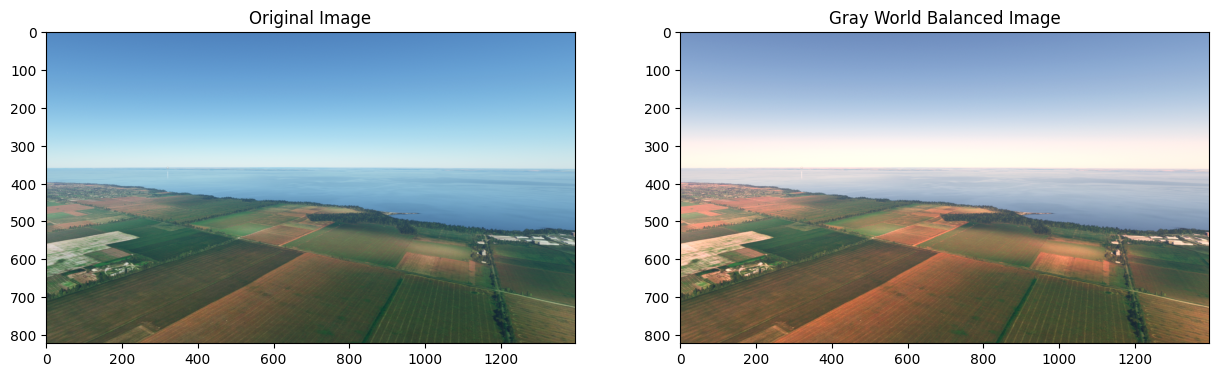

In [7]:
# Compute the mean values for all three colour channels (red, green, blue)
mean_r = np.mean(img[:, :, 0])
mean_g = np.mean(img[:, :, 1])
mean_b = np.mean(img[:, :, 2])

kr = mean_b / mean_r
kg = mean_b / mean_g
kb = 1

# Apply color balancing and generate the balanced image
balanced = np.zeros_like(img, dtype=np.float32)
balanced[:, :, 0] = img[:, :, 0] * kr
balanced[:, :, 1] = img[:, :, 1] * kg
balanced[:, :, 2] = img[:, :, 2] * kb

# Clip the values to ensure they are within the valid range [0, 255]
balanced = np.clip(balanced, 0, 255).astype(np.uint8)

# Show the original and the balanced image side by side
plt.subplot(121), plt.imshow(img)
plt.title('Original Image')
plt.subplot(122), plt.imshow(balanced)
plt.title('Gray World Balanced Image')
plt.show()


## Scale-by-max

Га гістограмі бачимо, що на наявному зображенні значення пікселів рівномірно розподілені і мають широкий спектр інтенсивності, тому даний метод не призведе до помітних змін. З цих причин візьмемо зображення з наведених даних до лабораторної роботи.

(Text(0.5, 0, 'Pixel color'), Text(0, 0.5, 'CDF'))

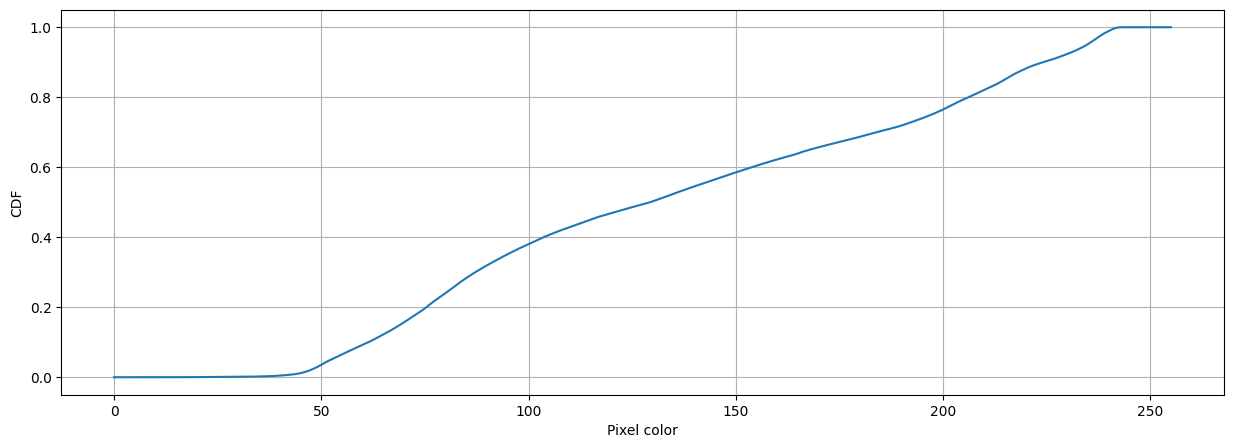

In [8]:
cdf = np.zeros(256)
for idx, h in enumerate(hist):
    cdf[idx] = np.sum(hist[0:idx+1])
cdf = cdf/np.sum(hist)
plt.plot(cdf), plt.grid(True)
plt.xlabel('Pixel color'), plt.ylabel('CDF')

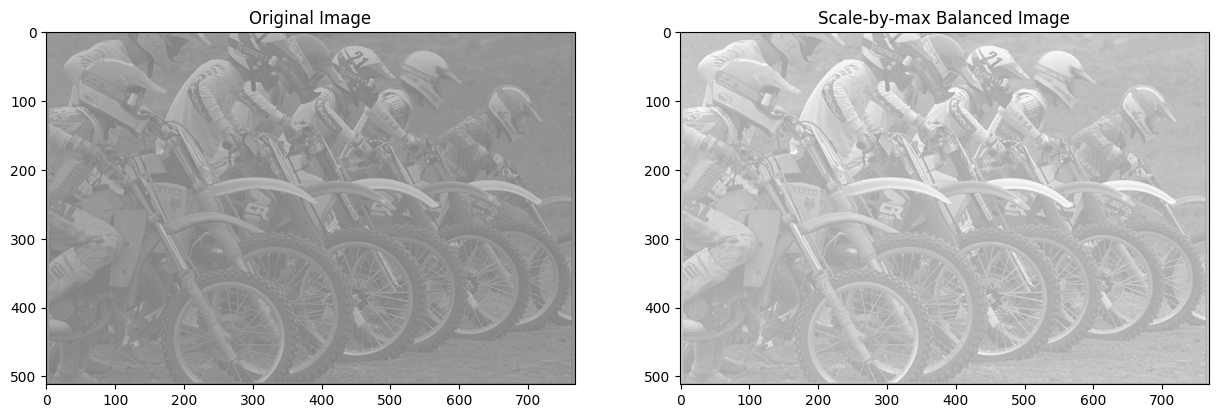

In [9]:
img = cv2.imread('kodim05.jpg')  # Завантажте своє зображення
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Compute the maximum values for all three colour channels (red, green, blue)
max_r = np.max(img[:, :, 0])
max_g = np.max(img[:, :, 1])
max_b = np.max(img[:, :, 2])

# Apply scale-by-max balancing and generate the balanced image
balanced = np.zeros_like(img, dtype=np.float32)
balanced[:, :, 0] = img[:, :, 0] / max_r
balanced[:, :, 1] = img[:, :, 1] / max_g
balanced[:, :, 2] = img[:, :, 2] / max_b

# Clip the values to ensure they are within the valid range [0, 1]
balanced = np.clip(balanced, 0, 1)

# Show the original and the balanced image side by side
plt.subplot(121), plt.imshow(img)
plt.title('Original Image')
plt.subplot(122), plt.imshow(balanced)
plt.title('Scale-by-max Balanced Image')
plt.show()
